In [1]:
import torch
import torch.backends.cudnn as cudnn
cudnn.benchmark = True

import numpy as np
import pandas as pd

from utils.function import set_seed
from config import get_params

config = get_params()
set_seed(
    seed=config['seed']
)
config

{'sampel_metric_path': './ckpt/dehazing/test_metric.json',
 'checkpoint_dir': './ckpt/dehazing',
 'data_dir': './dataset/SateHaze1k',
 'model_name': 'RSHazeNetFPNRes2NetGatedSKFusion2',
 'net_depth': (2, 2, 2),
 'crop_size': (256, 256, 3),
 'device': device(type='cuda', index=0),
 'batch_size': 14,
 'val_batch_size': 14,
 'test_batch_size': 1,
 'lr': 0.0002,
 'epochs': 1000,
 'n_workers': 0,
 'seed': 42,
 'n_class': 6}

In [2]:
# Colors
class_df = pd.DataFrame.from_dict({
    'class_name':['unlabeled','built-up','farmland','forest','meadow','water'],
    'r':[0, 255, 0, 0, 255, 0],
    'g':[0, 0, 255, 255, 255, 0],
    'b':[0, 0, 0, 255, 0, 255]
})

semantic_color = np.array(class_df[['r','g','b']].values.tolist())

In [3]:
import json
import os

save_data = None
with open(f"./dataset/GID5/data_split.json", "r") as f: # data_split_final
    save_data = json.load(f)

path = "./dataset/GID5"
train_datasets = np.column_stack((
    [os.path.join(path, 'cirrus_fix', i.split('/')[-1]) for i in save_data["train"]["hazy"]],
    [os.path.join(path, 'clear', i.split('/')[-1]) for i in save_data["train"]["clear"]],
    [os.path.join(path, 'mask', i.split('/')[-1]) for i in save_data["train"]["mask"]]
))

val_datasets = np.column_stack((
    [os.path.join(path, 'cirrus_fix', i.split('/')[-1]) for i in save_data["val"]["hazy"]],
    [os.path.join(path, 'clear', i.split('/')[-1]) for i in save_data["val"]["clear"]],
    [os.path.join(path, 'mask', i.split('/')[-1]) for i in save_data["val"]["mask"]]
))

test_datasets = np.column_stack((
    [os.path.join(path, 'cirrus_fix', i.split('/')[-1]) for i in save_data["test"]["hazy"]],
    [os.path.join(path, 'clear', i.split('/')[-1]) for i in save_data["test"]["clear"]],
    [os.path.join(path, 'mask', i.split('/')[-1]) for i in save_data["test"]["mask"]]
))

print(train_datasets.shape)
print(val_datasets.shape)
print(test_datasets.shape)

(6552, 3)
(2184, 3)
(2184, 3)


# Dataloader

In [4]:
# Pytorch
from utils.mtl_dataloader import DatasetGenerator
from torch.utils.data import DataLoader

train_generator = DatasetGenerator(
    semantic_color=semantic_color,
    file_path=train_datasets,
    input_size=config['crop_size'][::-1],
    train=True,
)

val_generator = DatasetGenerator(
    semantic_color=semantic_color,
    file_path=val_datasets,
    input_size=config['crop_size'][::-1],
    train=False
)

test_generator = DatasetGenerator(
    semantic_color=semantic_color,
    file_path=test_datasets,
    input_size=config['crop_size'][::-1],
    train=False
)

# Konfigurasi batch size
dataloaders = {
    'train': DataLoader(train_generator, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=False, num_workers=config['n_workers']),
    'val': DataLoader(val_generator, batch_size=config['val_batch_size'], shuffle=False, pin_memory=True, drop_last=False, num_workers=config['n_workers']),
    'test': DataLoader(test_generator, batch_size=config['test_batch_size'], shuffle=True, pin_memory=True, drop_last=False, num_workers=config['n_workers']),
}
phase_lists = [i for i in list(dataloaders.keys()) if i not in ['test']]

torch.Size([1, 3, 256, 256])


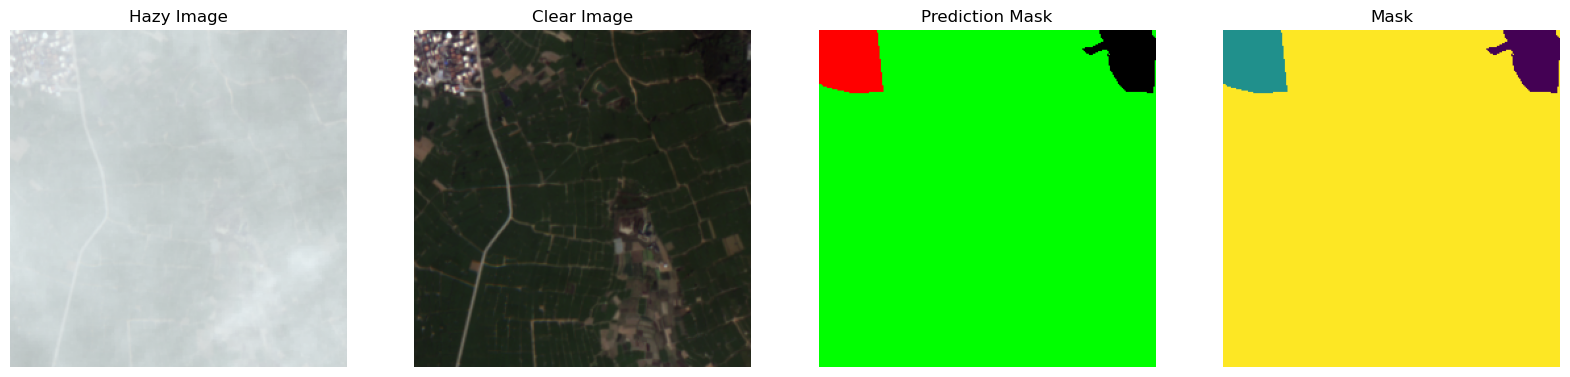

In [5]:
import matplotlib.pyplot as plt

data_test = iter(dataloaders['test'])
x, y_rec, y_seg = next(data_test)

plt.figure(figsize=(5*4, 5))
print(x.shape)
ax1 = plt.subplot(1, 4, 1)
ax1.imshow(x.numpy()[0].transpose((1, 2, 0)))
ax1.set_title('Hazy Image')
ax1.axis('off')

ax2 = plt.subplot(1, 4, 2)
ax2.imshow(y_rec.numpy()[0].transpose((1, 2, 0)))
ax2.set_title('Clear Image')
ax2.axis('off')

ax3 = plt.subplot(1, 4, 3)
ax3.imshow(semantic_color[y_seg.numpy()[0].transpose((0, 1))])
ax3.set_title('Prediction Mask')
ax3.axis('off')

ax4 = plt.subplot(1, 4, 4)
ax4.imshow(y_seg.numpy()[0].transpose((0, 1)))
ax4.set_title('Mask')
ax4.axis('off')
plt.show()

# Model

In [6]:
from net.MTLRSFPNPlusPlus import RSHazeNet
from thop import profile, clever_format
from torchsummary import summary
import torch

model = RSHazeNet(
    in_chans=3, 
    out_chans=4,
    dim=32,
    depths=config['net_depth']
).to(config['device'])
macs, params = profile(model, inputs=(x.to(config['device']), ))
macs, params = clever_format([macs, params], "%.3f")
print('macs', macs)
print('params', params)
summary(model, config['crop_size'][::-1], device=config['device'])

D:\WindowsApp\miniconda3\envs\pytorch\lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pixelshuffle.PixelShuffle'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register count_softmax() for <class 'torch.nn.modules.activation.Softmax'>.
macs 17.914G
params 1.432M
Layer (type:depth-idx)                        Output Shape              Param #
├─OverlapPatchEmbed: 1-1                      [-1, 32, 256, 256]        --
|    └─Conv2d: 2-1                            [-1, 32, 256, 256]        864
├─Sequential: 1-2                             [-1, 32, 256, 256]        --
|    └─ConvBlock: 2-2                         [-1, 32, 256, 256]        --
|    | 

Layer (type:depth-idx)                        Output Shape              Param #
├─OverlapPatchEmbed: 1-1                      [-1, 32, 256, 256]        --
|    └─Conv2d: 2-1                            [-1, 32, 256, 256]        864
├─Sequential: 1-2                             [-1, 32, 256, 256]        --
|    └─ConvBlock: 2-2                         [-1, 32, 256, 256]        --
|    |    └─Res2NetBottleneck: 3-1            [-1, 32, 256, 256]        3,552
|    └─ConvBlock: 2-3                         [-1, 32, 256, 256]        --
|    |    └─Res2NetBottleneck: 3-2            [-1, 32, 256, 256]        3,552
├─Downsample: 1-3                             [-1, 64, 128, 128]        --
|    └─Sequential: 2-4                        [-1, 64, 128, 128]        --
|    |    └─Conv2d: 3-3                       [-1, 16, 256, 256]        4,608
|    |    └─PixelUnshuffle: 3-4               [-1, 64, 128, 128]        --
├─Sequential: 1-4                             [-1, 64, 128, 128]        --
|    └─Con

# Train

In [7]:
# from utils.mtl_train import train_model

# checkpoint_path = "./ckpt/mtl/ProposedBranchHomoeSedastic3.pth"

# train_model(
#     dataloaders,
#     model,
#     device=config['device'],
#     semantic_color=semantic_color,
#     phase_lists=phase_lists,
#     n_class=6,
#     optimizer_lr=config['lr'],
#     num_epochs=config['epochs'],
#     checkpoint_path=checkpoint_path,
#     resume=False,
#     visualize_factor=20 # Every 20 epoch visualize a sample
# )

# Test

In [8]:
model.load_state_dict(
    torch.load(
        './ckpt/mtl/Hazy/ProposedBranchHomoeSedastic3._bestdice.pth',
        map_location=torch.device(config['device'])
    )['model']
)
model.eval
print("Weights loaded")

Weights loaded


In [9]:
from utils.validation import evaluation_metric

test_score = evaluation_metric(
    default_path="./image",
    metrics_path="./ckpt/mtl/validation_metric.json",
    model=model, 
    datasets=test_datasets,
    n_class=6, 
    device=config['device'],
    colour_codes=semantic_color,
    module="MTL2BranchAdaptiveWeights",
    is_hazy=True
)
print('Dice: ', test_score["dice"])
print('IoU: ', test_score["iou"])
print('OA: ', test_score["oa"])
print('mDice: ', np.nanmean(np.asarray(test_score["dice"])))
print('mIoU: ', test_score['miou'])
print('PSNR: ', test_score['psnr'])
print('SSIM: ', test_score['ssim'])
print('Time: ', test_score['times'])

100%|██████████████████████████████████████████████████████████████████████████████| 2184/2184 [11:37<00:00,  3.13it/s]


Dice:  [0.50338876 0.63484794 0.72229534 0.6773777  0.15859146 0.37167355]
IoU:  [0.33635238 0.46503833 0.56530696 0.51214755 0.08612508 0.22825497]
OA:  0.58074266
mDice:  0.5113625
mIoU:  0.36553755
PSNR:  20.58883929754788
SSIM:  0.8039104783116079
Time:  0.12951432228525042
